In [2]:
import numpy as np
import pylab as plt

In [3]:
def k_matrix(E, I, L, nc, p):
    """
    This function is designed to obtain the stiffness matrix of the structure based 
    on the number of columns and floors; it also outputs this matrix
    Args:
    E: Modulus of elasticity
    I: Moment of inertia of the cross-section
    L: Length of the columns
    nc: numbers of columns
    p: numbers of floors
    """
    k = np.zeros([p+1, p+1])
    el = nc*(12*(E*I)/(L**3))
    kp = el*np.array([[1, -1],
                      [-1, 1]])
    for i in range(0, p):
        k[i:i+2, i:i+2] += kp
    k = k[1:p+1, 1:p+1]
    return k

def inertia(op, b, h=0):
    """
    This function is designed to obtain inertia of the columns, according to the form
    geometric
    Args:
    op: Option geometry of column [1: rectangle, 2: circle, 3: square]
    b: slide 1 (if option 2 it's diameter of circle)
    h: slide 2 (if it's rectangle)
    """

    if op==1:
        I = (b*h**3)/12      
    elif op==2:
        I = (1/64)*(np.pi)*(b**4)
    elif op==3:      
        I = (b**4)/12
    else:
        a = print("Inertia not compatible")
        I = a      
    return I

def m_matrix(m, p):
    """
    This function is performed to obtain the mass matrix of any dynamic problem
    Args:
    m: concentrated mass
    p: number of floors
    """
    m_m = np.zeros([p, p])      
    for i in range(0, p):
        m_m[i, i] += m
    return m_m

def Dynamic_properties(k, m):
    """
    This function was created to obtain certain dynamic properties to subsequently
    obtain the dynamic response of the structure
      Args:
      k: Stiffness matrix
      m: mass matrix
      Return:
      intensity: Participation factors
      omega: Natural frequencies of each mode of vibration
      modes: Modes of vibration
    """
    from scipy.linalg import eig
    eigvals = eig(k, m)[0]
    eigvecs = eig(m, k)[1]
    omega = np.sqrt(np.real(eigvals))
    omega = sorted(omega) # reorganized frequencies
    omega = np.array(omega)
    freq = (2*np.pi)/omega
    Fp = [] # arrays to save the info of participation factor
    modes = []

    for i in range(len(eigvecs)):
        column = eigvecs[:,i].reshape(-1,1)
        col_max = np.max(column)
        col_min = np.min(column)
        if abs(col_max)-abs(col_min)<0:
            column = column/col_min
        else:
            column = column/col_max
        modes.append(column)

    for i in range(len(eigvals)):
        Mo = 0
        Lo = 0
        for j in range(len(eigvals)):
            Mo += m[j][j]*modes[i][j][0]**2
            Lo += m[j][j]*modes[i][j][0]
        so = Lo/Mo
        Fp.append(so)

    return omega, freq, modes, Fp

def auxiliar_function(wn, xi, Tf, a_o):
    """
    This function get displacement function axuliar according to Chopra (4ed)
    Args:
    wn: natural frequencies
    xi: Damping ratio
    Tf: Forced frequencies
    a_o: aceleration (range max)
    """
    wd = wn*(1-xi**2)**0.5
    w = (2*np.pi)/Tf
    E = (1-(w/wn)**2)**2+(2*xi*(w/wn))**2
    C = -(a_o/wn**2)*((2*xi*(w/wn))/E)
    D = (a_o/wn**2)*((1-(w/wn)**2)/E)
    A = -C
    B = (A*xi*wn-D*w)/wd
    t = np.linspace(0, 20, 1000)
    u_t = np.exp(-wn*xi*t)*(A*np.cos(wd*t)+B*np.sin(wd*t))+(
          C*np.cos(w*t)+D*np.sin(w*t))
    return u_t
    
def Displacement(k, m, xi, Tf, a_o):
    """
    This function is used to get displacement in the n floors, according with
    matrix stiffness or mass
    Args:
    k: matrix stiffness
    m: matrix mass
    xi: Damping ratio
    Return:
    Displacement
    """
    modes_shape = Dynamic_properties(k, m)[2]
    Participation_factor = Dynamic_properties(k, m)[3]
    omega = Dynamic_properties(k, m)[0]
    Displacement_gen = []
    for i in range(len(modes_shape)):
        u_t = 0
        for j in range(len(modes_shape)):
            u_t += modes_shape[j][i]*auxiliar_function(
                float(omega[j]), xi, Tf, a_o
            )*float(Participation_factor[j])
        Displacement_gen.append(u_t)
    max_displacement = np.max(u_t)
    max_displacement_t = f'The maximum displacement experienced is: {round(max_displacement,4)} m'
    return Displacement_gen, max_displacement_t, max_displacement

def Animation_Displacement(g_t, l, bmax):
    """
    This function was created to animate displacement for floor in the any structure
    Args:
    g_t: graphs to displacement
    l: height floor
    bmax: maximum displacement for scaling the x-axis
    Return:
    gif structure in motion
    """
    from matplotlib.animation import FuncAnimation, PillowWriter
    import matplotlib.pyplot as plt

    # Create figure and axes
    fig, ax = plt.subplots()
    
    # Initialize to line
    line1, = ax.plot([], [], color='black')  # to static structure
    points, = ax.plot([], [], 'ro', label='Concentrated mass')  # concentrated mass
    line_between_points, = ax.plot([], [], color='black', 
                                   linestyle='--') # line
    
    # settings limits of axes
    ax.set_ylim(0, l * (len(g_t) + 1))
    ax.set_xlim(-0.4, 0.4 if bmax * 3 < 0.25 else bmax * 1.1)
    ax.legend(loc='upper right')
    ax.grid()

    # Function to initialize animation
    def init():
        line1.set_data([], [])
        points.set_data([], [])
        line_between_points.set_data([], [])

        return line1, points, line_between_points

    # Function update
    def update(frame):
        # Static structure
        x1 = np.zeros(len(g_t) + 1)
        y1 = [l * i for i in range(len(g_t) + 1)]
        line1.set_data(x1, y1)

        # concentred mass
        x_masses = [g_t[i][frame] for i in range(len(g_t))]
        y_masses = [l * (i + 1) for i in range(len(g_t))]
        x_masses_line = [0] + x_masses
        y_masses_line = [0] + [l * (i + 1) for i in range(len(g_t))]
        points.set_data(x_masses, y_masses)
        line_between_points.set_data(x_masses_line, y_masses_line)

        return line1, points, line_between_points

    # animate setting
    ani = FuncAnimation(fig, update, frames=len(g_t[0]), init_func=init, 
                        interval=1000, repeat=False)

    # save GIF
    ani.save("animation_displacement.gif", writer=PillowWriter(fps=6))
    return "The diagram has been generated correctly!"

def maxium_displacement_relative(g_t, l):
    """
    This function is created to obtain maxium displacement
    relative in any structure
    g_t: graphs to displacement
    """
    maxs = []
    for i in range(len(g_t)):
        if i==0:
            maxs.append(round(
                float(np.max(abs(g_t[i])))*(100/l),3))
        else:
            maxs.append(round(
                float(np.max(abs(g_t[i])-abs(g_t[i-1]))*(100/l)),3))
    return maxs

def Forces_general(k, m, l, xi, T_f, a_o, g):
    """
    This function is performed to obtain the corresponding dynamic forces: 
    tipping moments, basal shear, shear and bending moments of the floors. 
    Note: it is assumed that all floors are the same, if this is not the 
    case it is necessary to modify the code
    Args:
    k: stiffness matrix
    m: mass matrix
    l: Height
    p: number of floors
    xi: Damping ratio
    T_f: Forced frequencies
    a_o: aceleration (range max)
    g: gravity
    """
    wns = Dynamic_properties(k, m)[0]
    u_t = []
    for i in range(len(wns)):
        u_t.append(auxiliar_function(float(wns[i]), xi, T_f, a_o)) # function of displacement (auxiliar)
    phis = Dynamic_properties(k, m)[2]
    Participation_factors = Dynamic_properties(k, m)[3]
    ## First of all, report vector s
    s = []
    for i in range(len(phis)):
        s.append(
        float(Participation_factors[i])*np.dot(m, phis[i])
        )
    ## First of all obtained shears
    Vb1 = []
    for i in range(len(u_t)):
        Vaux1 = 0
        for j in range(len(u_t)):
            Vaux1 += (s[j][i]/g)*u_t[j]*wns[j]**2
        Vb1.append(Vaux1)
    Vbt = 0
    for i in range(len(Vb1)):
        Vbt += Vb1[i] 
    Vb_max1 = float(np.max(Vbt))
    Vb_max2 = float(np.min(Vbt))
    Vgra = []
    for i in range(len(u_t)):
        if i ==0:
            Vaux = 0
        else:
            Vaux -= Vb1[i-1]
        Vgra.append(Vbt+Vaux)
    if Vb_max1 < abs(Vb_max2):
        Vb_max = -Vb_max2
    else:
        Vb_max = Vb_max1
    ## Obtained moments
    Mbt=0
    for i in range(len(Vb1)):
        Mbt += Vb1[i]*l*(i+1)
    Mb = []
    Maux = 0
    for i in range(len(Vb1)):
        if i==0:
            Vaux = Vbt
            Maux = Vaux*l
        else:
            Vaux -= Vb1[i-1]
            Maux += Vaux*l
        Mb.append(-Mbt+Maux)
    Mb_max1 = float(np.max(Mbt))
    Mb_max2 = float(np.min(Mbt))
    if Mb_max1 < abs(Mb_max2):
        Mb_max = -Mb_max2
    else:
        Mb_max = Mb_max1
    
    return Vgra, Vb_max, Vgra[0], Mbt, Mb, Mb_max

## Entry data

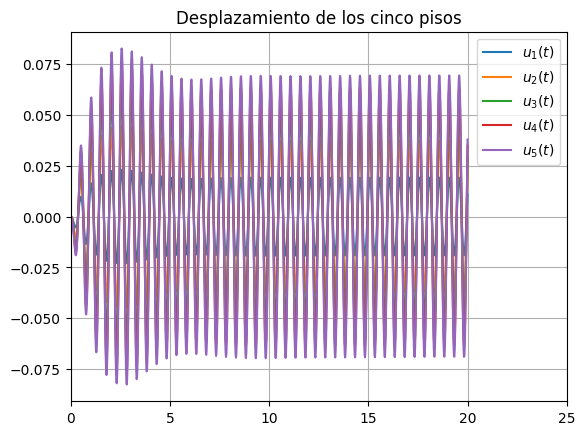

In [16]:
# Inputs
T = 0.5 # s
wl = 1 # tonf/m²
a = 20*20 # m²
Ag = 0.15 #factor
ml = wl*a # tonf
xi = 5/100 #%
E = 2e6*9.81 # tonf/m²
I = inertia(3, 0.4) #m^4
L = 3 # m
k = k_matrix(E, I, L, 36, 5)
m = m_matrix(ml, 5)
a = Dynamic_properties(k, m)
b, b_max, b_max_n = Displacement(k, m, xi, T, -Ag*9.81)

t = np.linspace(0, 20, 1000)
for i in range(len(b)):
    plt.plot(t, b[i], label=f'$u_{i+1}(t)$')
plt.title('Displacement of the 5 floors')
plt.grid()
plt.legend(loc='upper right')
plt.xlim(0, 25)
plt.show()

##  Animation

'¡El diagrama se ha entregado correctamente!'

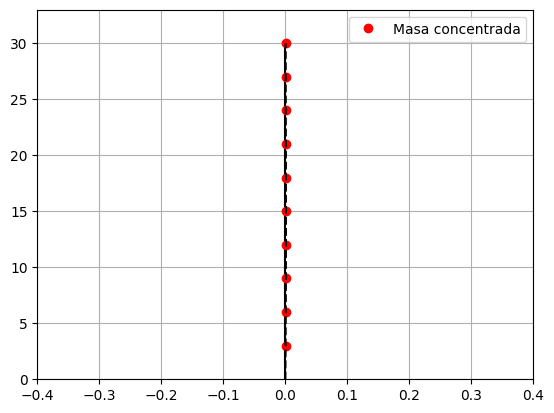

In [5]:
Animation_Displacement(b, 3, b_max_n)

## Maximum drifts

In [17]:
maxium_displacement_relative(b, L)

[0.769, 0.72, 0.605, 0.437, 0.229]

## Dynamic forces

### Graph of the shears

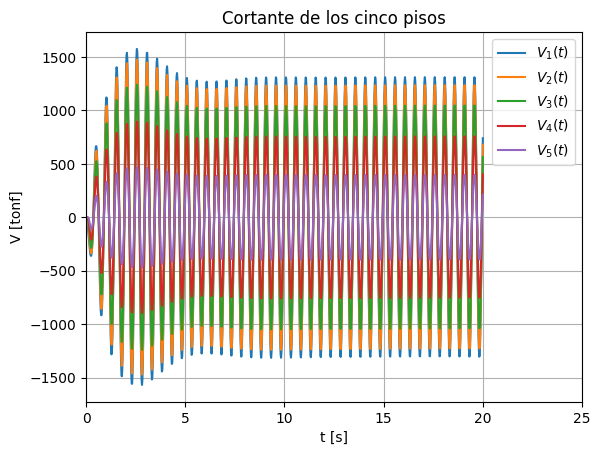

In [18]:
a = Forces_general(k, m, 3, xi, T, -Ag*9.81, 9.81)[0]
for i in range(len(a)):
    plt.plot(t, a[i], label=f'$V_{i+1}(t)$')
plt.title('Shear of the 5 floors')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('t [s]')
plt.ylabel('V [tonf]')
plt.xlim(0, 25)
plt.show()

### Graph of the shear basal

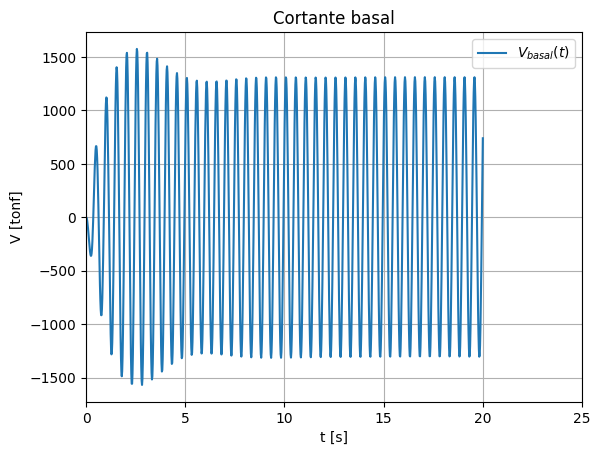

In [19]:
b = Forces_general(k, m, 3, xi, T, -Ag*9.81, 9.81)[2]
plt.plot(t, b, label='$V_{basal}(t)$')
plt.title('Shear basal')
plt.grid()
plt.legend(loc='upper right')
plt.ylabel('V [tonf]')
plt.xlabel('t [s]')
plt.xlim(0, 25)
plt.show()

### Maximum shear

In [9]:
print(f"The maximum shear is {int(Forces_general(k, m, 3, xi, T, -Ag*9.81, 9.81)[1])} tonf")

El cortante máximo basal es 376 tonf


### Graph of the moments

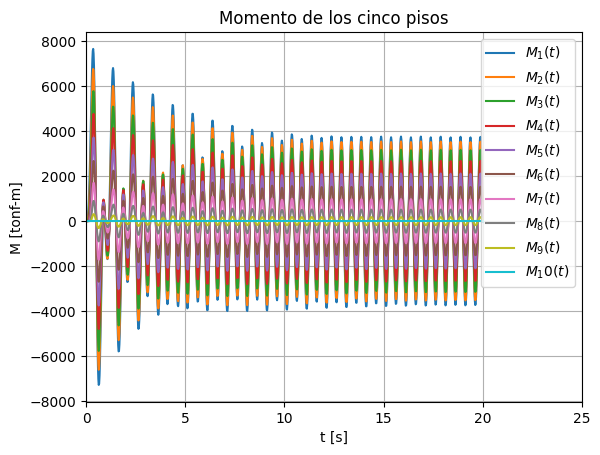

In [10]:
a = Forces_general(k, m, 3, xi, T, -Ag*9.81, 9.81)[4]
for i in range(len(a)):
    plt.plot(t, a[i], label=f'$M_{i+1}(t)$')
plt.title('Moment bending of the 5 floors')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('M [tonf-m]')
plt.legend(loc='upper right')
plt.xlim(0, 25)
plt.show()

### Graph of the moment

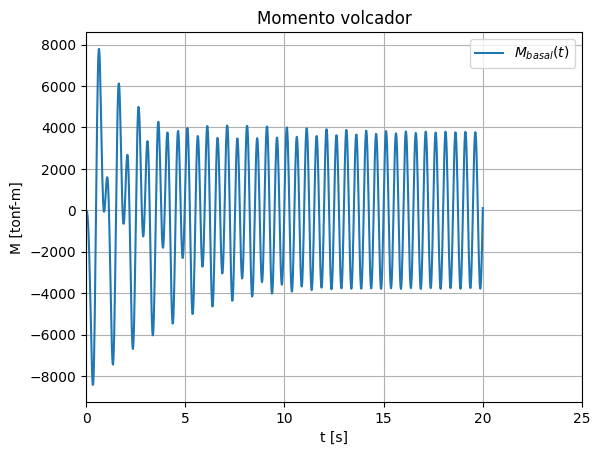

In [11]:
b = Forces_general(k, m, 3, xi, T, -Ag*9.81, 9.81)[3]
plt.plot(t, b, label='$M_{basal}(t)$')
plt.title('Overturning moment')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('M [tonf-m]')
plt.legend(loc='upper right')
plt.xlim(0, 25)
plt.show()

### Maximum moment basal

In [12]:
print(f"The maximum moment basal is {int(Forces_general(k, m, 3, xi, T, -Ag*9.81, 9.81)[5])} tonf-m")

El momento máximo basal es 8426 tonf-m
